# Pets Facial Expression Using  ViT

In [2]:
!pip install -q evaluate transformers datasets mlflow

In [3]:
# imports
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             classification_report, 
                             f1_score)

import evaluate
from datasets import Dataset, Image
from transformers import (TrainingArguments, 
                          Trainer, 
                          ViTImageProcessor, 
                          ViTForImageClassification,
                          DefaultDataCollator)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)

2024-06-20 05:26:17.705686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 05:26:17.705800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 05:26:17.865476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1074 1074


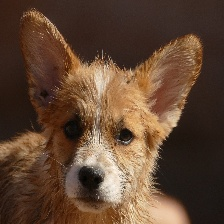

In [4]:
image_dict = {}
# Define the list of file names
from pathlib import Path
file_names = []
labels = []
for file in Path('/kaggle/input/pets-facial-expression-dataset/Master Folder/').glob('*/*/*.jpg'):
    file_names.append(str(file))
    label = str(file).split('/')[-2]
    labels.append(label)
print(len(file_names), len(labels))

dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())
dataset[0]["image"]

In [5]:
labels_list = list(set(labels))
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'Other', 1: 'Angry', 2: 'Sad', 3: 'happy'} 

 {'Other': 0, 'Angry': 1, 'Sad': 2, 'happy': 3}


In [6]:
dataset = dataset.train_test_split(test_size=0.2)
train_data = dataset['train']
test_data = dataset['test']

In [7]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


In [8]:
# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [9]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.801732


In [10]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    
    return {
        "accuracy": acc_score
    }

In [11]:
metric_name = "accuracy"
model_name = "pets_facial_expression_detection"
num_train_epochs=20
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1, 
    report_to="mlflow", 
)

In [12]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)
trainer.evaluate()

{'eval_loss': 1.390535593032837,
 'eval_accuracy': 0.22790697674418606,
 'eval_runtime': 63.2736,
 'eval_samples_per_second': 3.398,
 'eval_steps_per_second': 0.853}

In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.380761,0.279070
2,No log,1.352084,0.358140
3,No log,1.309082,0.483721
4,No log,1.254239,0.534884
5,No log,1.207657,0.572093
6,No log,1.162784,0.595349
7,No log,1.114536,0.609302
8,No log,1.067723,0.651163
9,No log,1.026270,0.660465
10,No log,0.987448,0.688372


TrainOutput(global_step=540, training_loss=0.8820357428656684, metrics={'train_runtime': 18196.8092, 'train_samples_per_second': 0.944, 'train_steps_per_second': 0.03, 'total_flos': 1.3313362458422477e+18, 'train_loss': 0.8820357428656684, 'epoch': 20.0})

In [14]:
trainer.evaluate()

{'eval_loss': 0.7929731607437134,
 'eval_accuracy': 0.8,
 'eval_runtime': 67.2387,
 'eval_samples_per_second': 3.198,
 'eval_steps_per_second': 0.803,
 'epoch': 20.0}

In [15]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.7929731607437134, 'test_accuracy': 0.8, 'test_runtime': 75.1406, 'test_samples_per_second': 2.861, 'test_steps_per_second': 0.719}


In [16]:
%matplotlib inline

Accuracy: 0.8000
F1 Score: 0.8004


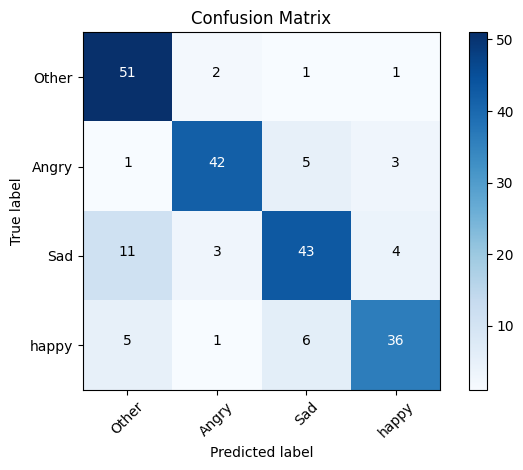

In [17]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels_list)